In [1]:
# Basic imports
import sys

# System path modification
sys.path.insert(0, '..')

import nibabel as nib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nilearn.image import new_img_like

from nilearn import plotting
import numpy as np
import seaborn as sns

from src.dataset import *

# Feature Attribution Brain Maps

This notebook projects model-derived feature attributions from MRI cortical thickness data onto brain maps using the Schaefer atlas (200 parcels, 7 functional networks). Attribution scores are computed with permutation-based methods (ShapleyValueSampling, Occlusion, FeatureAblation, FeaturePermutation, KernelShap, Lime) and visualized in anatomical and functional brain space using Nilearn. Metrics are computed target-wise, and one brain map is generated per target and per explainer method. All outputs are saved to designated folders.

---

### Notebook Structure

1. Load Data
2. Import Schaefer Atlas and Map Features to Brain Regions
3. Generate Brain Maps and Attribution Comparisons

## Load data 

In [2]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

In [3]:
data.keys()

dict_keys(['df_X', 'df_y', 'df_all', 'df_FinalCombination', 'dict_select', 'df_select_features', 'colormaps'])

#  Import Schaefer Atlas and Map Features to Brain Regions

In [4]:
select_MRIthickness = [x.replace("_Cortical", "") for x in select_MRIthickness]

In [5]:
local_matrix = pd.read_csv('../pickle/TabNet_local_MRI.csv', names=["Importance"], header=None)
local_matrix.index = select_MRIthickness

In [6]:
mmse_template = pd.read_csv('../figures/adni_feature_importances_MMSE.csv')
mmse_template.set_index("feature", inplace=True)

In [7]:
local_matrix = local_matrix.reindex(index=mmse_template.index)

In [8]:
atlas_path = '../figures/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz'  # Path to the atlas
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Load region label map from data/AD/Schaefer2018_200Parcels_7Networks_order_info.txt, each line is feature_name,region_label
region_label_map = pd.read_csv('../figures/Schaefer2018_200Parcels_7Networks_order_info.txt')
region_label_map = region_label_map.set_index('feature_name')['region_label']

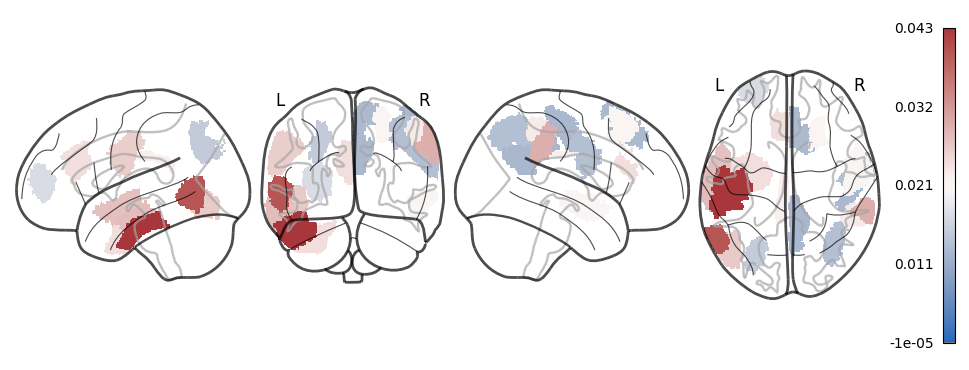

In [9]:
df = local_matrix.reset_index(names="feature").rename(columns={"Importance":"importance"})

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['abs_importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap="vlag",
    display_mode='lyrz',
)

plt.savefig(f'../figures/adni_brain_tabnet_local.png')
# Show the plot
plotting.show()

# Generate Brain Maps and Attribution Comparisons

In [10]:
def plot_top_brain_importances(
    perturbation_matrix: pd.DataFrame,
    metric_name: str,
    select_features: list,
    atlas_data: np.ndarray,
    atlas_img,
    region_label_map: dict,
    output_dir: str,
    vmax: float = None,
    n_top: int = 20,
    cmap: str = "vlag"
):
    """
    Plot brain importance maps from a permutation importance matrix using a brain atlas.

    Args:
    - permutation_matrix (pd.DataFrame): DataFrame with shape [n_features, n_targets].
    - select_features (list): Ordered list of features matching brain atlas regions (used as index).
    - atlas_data (np.ndarray): 3D atlas data with integer labels for each brain region.
    - atlas_img (nib.Nifti1Image): NIfTI image of the atlas, used for creating new images.
    - region_label_map (dict): Maps feature names to atlas integer region labels.
    - metric_name (str) : Name under which to save the plot files.  
    - output_dir (str): Directory to save plots.
    - vmax (float, optional): Max value for color scale. If None, computed from the matrix.
    - n_top (int): Number of top features to display.
    - cmap (str): Colormap for brain plot.
    """

    os.makedirs(output_dir, exist_ok=True)

    # Ensure correct indexing
    perturbation_matrix = perturbation_matrix.copy()
    perturbation_matrix.index = select_features

    # Reorder to match template
    perturbation_matrix = perturbation_matrix.reindex(index=select_features)

    # Determine vmax if not provided
    if vmax is None:
        vmax = round(perturbation_matrix.abs().max().max(), 2)

    for target in perturbation_matrix.columns:
        df = perturbation_matrix[target].reset_index().rename(columns={
            'index': 'feature',
            target: 'importance'
        })

        df['abs_importance'] = df['importance'].abs()
        df_sorted = df.sort_values(by='abs_importance', ascending=False).head(n_top)

        importance_map = np.zeros_like(atlas_data, dtype=np.float32)

        for _, row in df_sorted.iterrows():
            feature = row['feature']
            importance = row['abs_importance']
            region_idx = region_label_map.get(feature, None)

            if region_idx is not None:
                importance_map[atlas_data == region_idx] = importance

        importance_img = new_img_like(atlas_img, importance_map)

        # Plot and save
        fig = plotting.plot_glass_brain(
            importance_img,
            colorbar=True,
            cmap=cmap,
            display_mode='lyrz',
            vmin=0,
            vmax=vmax,
            title=f"{target} - Top {n_top} Regions"
        )

        fig.savefig(os.path.join(output_dir, f"brain_tabnet_{metric_name}_{target.lower().replace(' ', '_')}.png"))
        plt.close()

In [14]:
def extract_model_metric_target(filename):
    # Remove file extension
    parts = filename.replace('.csv', '').split('_')
    model = parts[0]
    metric = parts[1]
    return model, metric

In [ ]:
for brainfile in os.listdir("../figures/captum/brain_maps"): 
    if ".csv" in brainfile: 

        print(f"Processing : {brainfile}")
        model, metric = extract_model_metric_target(brainfile)

        # Load permutation matrix
        matrix = pd.read_csv(
            f"../figures/captum/brain_maps/{brainfile}",
            names=["Memory", "Executive Function", "Visuospatial", "Language"],
            header=None
        )

        # Set index and match templae
        matrix.index = select_MRIthickness

        # Plot
        plot_top_brain_importances(
            perturbation_matrix=matrix,
            select_features=mmse_template.index.tolist(),  # assuming same order
            atlas_data=atlas_data,
            atlas_img=atlas_img,
            region_label_map=region_label_map,
            metric_name=metric,
            output_dir="../figures/captum/brain_maps",
            vmax=None,  # optional
            n_top=30,
            cmap="magma_r"
        )

Processing : tabnet_kernelshap_to_brain.csv
Processing : tabnet_permutation_to_brain.csv
Processing : tabnet_lime_to_brain.csv
Processing : tabnet_ablation_to_brain.csv
Processing : tabnet_occlusion_to_brain.csv
Processing : tabnet_shapley_to_brain.csv


In [16]:
brainfile = "tabnet_shapley_to_brain.csv"

In [17]:
# Load permutation matrix
matrix = pd.read_csv(
    f"../figures/captum/brain_maps/{brainfile}",
    names=["Memory", "Executive Function", "Visuospatial", "Language"],
    header=None
)

# Set index and match templae
matrix.index = select_MRIthickness